In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
data = pd.read_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/representative regions/UKESM1-0-LL_2010_2014_representative_regions(ver240113).csv')

#### Calculate dynamic regression 

In [3]:
d_ch3o2_oh_beta = data.groupby('region').apply(lambda g: sm.OLS(g['ch3o2_mole'], g[['oh_mole']]).fit().params)
d_ch3o2_oh_ste = data.groupby('region').apply(lambda g: sm.OLS(g['ch3o2_mole'], g[['oh_mole']]).fit().HC0_se)

#### Calculate features

In [4]:
data['ch4__no'] = data['ch4_mole']/data['no_mole']
feat = data.groupby('region').mean()['ch4__no']
feat = pd.DataFrame(feat)
feat_std = data.groupby('region').std()['ch4__no']
feat_ct = data.groupby('region').count()['ch4__no']
feat_ste = pd.DataFrame(feat_std/np.sqrt(feat_ct/5))

In [5]:
mod = LinearRegression()
X = feat[['ch4__no']]
y = d_ch3o2_oh_beta['oh_mole']
mod.fit(X,y)
y_pred = mod.predict(X)

In [6]:
d_ch3o2_oh_beta['beta_adj'] = d_ch3o2_oh_beta['oh_mole']+0.5 + y_pred*0.5
d_ch3o2_oh_beta['ch4__no'] = feat['ch4__no']
d_ch3o2_oh_beta['beta_adj_ste'] = d_ch3o2_oh_ste
d_ch3o2_oh_beta['ch4__no_ste'] = feat_ste

([<matplotlib.axis.XTick at 0x7fb4147b31f0>,
 [Text(-1, 0, '−1'),
  Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

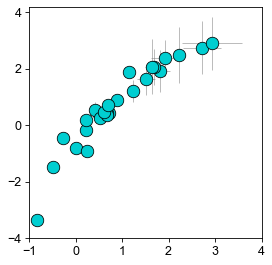

In [7]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=75)
x_values = np.log(d_ch3o2_oh_beta['beta_adj'])
y_values = np.log(d_ch3o2_oh_beta['ch4__no']*10**(-3))
x_errors = d_ch3o2_oh_beta['beta_adj_ste']
y_errors = d_ch3o2_oh_beta['ch4__no_ste']*10**(-3)

plt.errorbar(x_values, y_values, xerr=x_errors, yerr=y_errors, 
             fmt="o", ecolor="grey", elinewidth=0.5, capsize=None, mfc='darkturquoise', mec='black', ms=12, alpha=1, mew=0.75)

plt.xlim([-4,4])
plt.xlim([-1,4])
plt.yticks([-4,-2,0,2,4], fontsize=12)
plt.xticks([-1,0,1,2,3,4], fontsize=12)

In [9]:
d_ch3o2_oh_beta = d_ch3o2_oh_beta[['beta_adj', 'beta_adj_ste', 'ch4__no', 'ch4__no_ste']]
d_ch3o2_oh_beta['ln_beta_adj'] = np.log(d_ch3o2_oh_beta['beta_adj'])
d_ch3o2_oh_beta['ln_ch4__no'] = np.log(d_ch3o2_oh_beta['ch4__no']*10**(-3))

d_ch3o2_oh_beta.to_csv('I5 MeOO_OH.csv')